In [1]:
import pandas as pd
from warnings import warn
import re
import matplotlib.pyplot as plt
import numpy as np
import zlib # crc32
import crc

# https://docs.python.org/3/library/logging.html
# https://docs.python.org/3/howto/logging.html
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(filename='log/example.log', encoding='utf-8', level=logging.INFO)

In [2]:
"""This assumes a few things about the input data and then how that is processed"""
# Before capture...
# set speed!!!!
# https://phoenixnap.com/kb/ethtool-command-change-speed-duplex-ethernet-card-linux

'This assumes a few things about the input data and then how that is processed'

<Axes: >

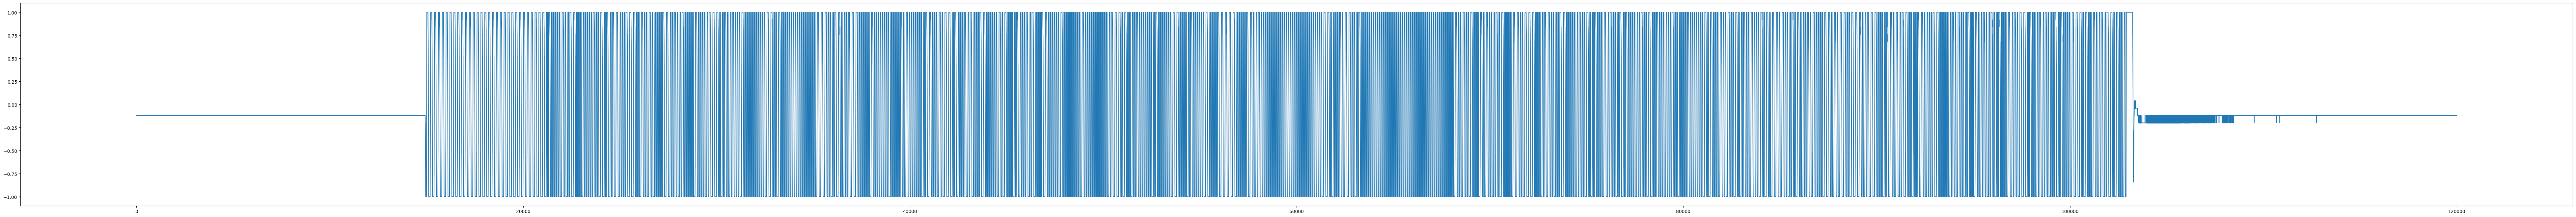

In [3]:
def clamp(val, minval=-1, maxval=1):
    if val < minval: return minval
    if val > maxval: return maxval
    return val

def get_capture(i=3, invert=False):
    
    """Get waveform capture data for NewFile{i}.csv, and optionally invert it.
    Data will be 'normalized' (clamped) from -1 to 1 V, for ease of visualization mostly.
    Compared with Ben Eater's result to realize that my wires were crossed and the preamble should 
    start with a dip-then-rise for the first bit logical 1 that the preamble starts off with.
    https://www.youtube.com/watch?v=xrVN9jKjIKQ  time 5:30 stillframe."""

    v_series = pd.read_csv(f'ethernet_captures/NewFile{i}.csv', skiprows=1).iloc[:, 1]
    if invert:
        v_series = -v_series
    
    v_series = v_series.apply(clamp)
    return v_series

# Preview
v_series = get_capture()
v_series.plot(figsize=(100, 8))

In [4]:
# Auto parse bitstream, parse the WAVEFORM to generate a bit-string

def sign(x):
    if x < 0: return -1
    if x > 0: return 1
    return 0

# Assume all edge transitions are 'clean', NO bouncing back once the voltage crosses 0
def edge(last, new):
    return sign(last) != sign(new)

def parse_manchester(v_series, ethernet_signal_T=1/10E6, wave_sample_T=1E-9):

    """Take voltage timeseries and return df of 1's and 0's per Manchester encoding (include preamble and SFD, entire transmission).
    Must provide the ethernet signalling period (T) and the oscilloscope/waveform sample period in seconds."""

    # Threshold of time we must pass from the last edge/bit to the next, so that we don't measure the intermediate 
    # edges that occur in Manchester encoding.
    thrsh = ethernet_signal_T * 0.7

    # initialize the mutables for iteration
    result = pd.Series()
    t = 0.0
    efd_t = 0.0 # end of frame delimeter... just when signal goes high for more than a full clock period
    last_v = -1
    for i, v in v_series.items():
        t += wave_sample_T # 1GHz from my Rigol oscilloscope
        efd_t += wave_sample_T
        if efd_t > (ethernet_signal_T * 1.5) and len(result) > 5:
            break
        
        # if we have passed half the signalling period... now we look for the 'real' edge
        # not just the intermediate edge if there was one, for manchester encoding.
        if t >= thrsh:
            if edge(last_v, v):
                t = 0.0
                efd_t = 0.0

                if sign(v) == 1:
                    result[i] = '1'
                else:
                    result[i] = '0'
                    
        last_v = v
    
    df = result.reset_index()
    df.columns = ['t', 'Q']
    return df

In [5]:
bit_df = parse_manchester(v_series)
rawbits = ''.join(bit_df.Q.tolist())
print(rawbits)
len(rawbits)

1010101010101010101010101010101010101010101010101010101010101011000000100110100001111110001011011010111101010001000100111110101110011000000100000110101001100110000100000000000010100010000000000000000000101010001101001110101000000010000000001111110010000000011010000100101011011110110111101000000010010000110111101101111010000000100000000001000000000000011010100100011100000000110000000010100000110000000101111101010101011111101001100000000000000000000000000000000010100111100101000110000000000000000000000000000000000000000000000000100010001000010010001100100000101000101010000110100011101000000110001001100001011000110110000011100010111000011110001111100000000100100001000100010011000100001001001010010001100100111001000001010010010100010101001101010000110100101101000111010011110100000011001000110001001100110011000010110010101100011011001110110000010101001000100110110100100011


880

In [6]:
def ffill_Q_index(df):
    # q index / bit index is n
    
    df = bit_df.reset_index().set_index('t')
    df.columns = ['n', 'Q']
    df = v_series.to_frame().join(df, how='left')
    df.n = df.n.ffill(limit=125) # this is so that shading the FCS doesn't shade to the end of the entire graph..
    df.n = df.n.fillna(-1)
    df.n = df.n.astype(int)
    #t.Q = t.Q.ffill()
    return df

df = ffill_Q_index(bit_df)
df.loc[~df.n.isna()]

Volt  n    Q
0      -0.12 -1  NaN
1      -0.12 -1  NaN
2      -0.12 -1  NaN
3      -0.12 -1  NaN
4      -0.12 -1  NaN
...      ... ..  ...
119995 -0.12 -1  NaN
119996 -0.12 -1  NaN
119997 -0.12 -1  NaN
119998 -0.12 -1  NaN
119999 -0.12 -1  NaN

[120000 rows x 3 columns]

In [7]:
# While my parsing script is simple, it might not capture the full preamble accurately.
# Thereofore, instead of searching for the full preamble + SFD, we just look for 
# 'a large portion of the preamble' which is 5 bytes of 01010101 and then the SFD, not caring what came at the very start.
# We take this to determine the starting bit index of the DEST MAC which we will call the start of the ethernet frame.
sfd = '10101011'
psuedo_preamble='.*'+'10101010'*5 + sfd
r = re.search(psuedo_preamble, rawbits)
preamble_length = len(r.group(0))

# calculate start of ethernet frame.
dest_mac_start = preamble_length
dest_mac_stop = dest_mac_start + 48
source_mac_start = dest_mac_stop
source_mac_stop = source_mac_start + 48
ethertype_start = source_mac_stop
ethertype_stop = ethertype_start + 16

fcs_start = len(rawbits) - 4*8
fcs_stop = len(rawbits)

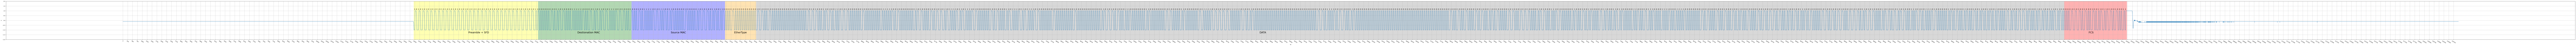

In [8]:
def compute_section_midpoint(df, start, end):
    local_midpoint = (start + end)//2
    p = int(df.loc[df.n == local_midpoint].reset_index().iloc[:, 0].mean())
    return p

# Plot the segments shaded over the raw waveform.
xticks = np.arange(0, len(df), 250)

fig, ax = plt.subplots()
plot = df.Volt.plot(
        figsize=(400, 6),  
        ax=ax, 
        xlabel='ns', 
        ylabel='V', 
        #color='red', 
        ylim=(-2, 2), 
        grid=True, 
        xticks=xticks
    )

xticks = np.arange(0, len(df), 10)
plt.xticks(rotation=-30)

# Shade regions for different sections of ethernet header, and annotate the sections
ax.fill_between(df.index, 4, -4, where=(df.n >= 0) & (df.n < dest_mac_start), facecolor='yellow', alpha=.3, offsets=(-15,0))
p = compute_section_midpoint(df, 1, dest_mac_start)
ax.annotate(text='Preamble + SFD', xy=(p-500, -1.35), fontsize=22)

ax.fill_between(df.index, 4, -4, where=(df.n >= dest_mac_start) & (df.n < source_mac_start), facecolor='green', alpha=.3, offsets=(-15,0))
p2 = compute_section_midpoint(df, dest_mac_start, dest_mac_stop)
ax.annotate(text='Destionation MAC', xy=(p2-500, -1.35), fontsize=22)

ax.fill_between(df.index, 4, -4, where=(df.n >= source_mac_start) & (df.n < ethertype_start), facecolor='blue', alpha=.3, offsets=(-15,0))
p3 = compute_section_midpoint(df, source_mac_start, source_mac_stop)
ax.annotate(text='Source MAC', xy=(p3-500, -1.35), fontsize=22)

ax.fill_between(df.index, 4, -4, where=(df.n >= ethertype_start) & (df.n < ethertype_stop), facecolor='orange', alpha=.3, offsets=(-15,0))
p4 = compute_section_midpoint(df, ethertype_start, ethertype_stop)
ax.annotate(text='EtherType', xy=(p4-450, -1.35), fontsize=22)

# red out 'data' section or make it gray, idk
# do I want to go into more depth like drill down to IP? not necesarilly. I want to use higher level 
# abstractions to look at that information, later, though. Just not on the bit stream... or do I? xD
ax.fill_between(df.index, 4, -4, where=(df.n >= ethertype_stop) & (df.n < fcs_start), facecolor='gray', alpha=.3, offsets=(-15,0))
p5 = compute_section_midpoint(df, ethertype_stop, 700)
ax.annotate(text='DATA', xy=(p5-450, -1.35), fontsize=22)

ax.fill_between(df.index, 4, -4, where=(df.n >= fcs_start) & (df.n < fcs_stop), facecolor='red', alpha=.3, offsets=(-15,0))
p6 = compute_section_midpoint(df, fcs_start, fcs_stop)
ax.annotate(text='FCS', xy=(p6-450, -1.35), fontsize=22)

for i, row in df.loc[~df.Q.isna()].iterrows():
    ax.annotate(text=row.Q, xy=(i - 40, 1.1), fontsize=15)  # 0.10

#fig.savefig('figure.png')

In [9]:
# Functions to parse the bit-string per ethernet spec

def chunk_octets(bits):
    n_bits = len(bits)
    n_octets = n_bits//8
    if (n_bits % 8) != 0:
        raise Exception("input bits are not a multiple of 8")
    chunked = [bits[(i*8):(i*8)+8] for i in range(n_octets)]
    logger.info(f"{n_octets} octets chunked")
    return chunked

def reverse_string(s):
    a = [s[len(s) - i - 1] for i in range(len(s))]
    flipped = ''.join(a)
    return flipped

def reverse_octets(a):
    return [reverse_string(octet) for octet in a]

# Hexify a single byte (pad=2)
def hexify(x, pad=2):
    return hex(int(x, base=2))[2:].rjust(pad, '0')

def macify(a):
    resNums = [hexify(x) for x in a]
    r = ':'.join(resNums)
    return r

In [10]:
# Let us take the entire received bit-stream and turn it into BYTES, knowing that they are sent 
# highest-to-lowest byte at a time, each byte sent LSB first.

frame_bits = rawbits[dest_mac_start:]

# Chop off any extra bits that make it not a multiple of 8
L = len(rawbits[dest_mac_start:])
L = -(L%8)
if L != 0:
    frame_bits = frame_bits[:L]
    warn("Had to chop off bits from the end to make mult of 8. Did end of frame detection fail?")

frame_bytes = reverse_octets(chunk_octets(frame_bits))

# preview
frame_bytes[:5]

['01000000', '00010110', '01111110', '10110100', '11110101']

In [11]:
# Some common EtherType codes.
ethertypes = pd.read_csv('ethertype.csv')
ethertypes.loc[ethertypes.Ethertype.str.contains('arp|ipv4|ipv6', regex=True, case=False)]

Hex                                   Ethertype
1762  0x0800          Internet Protocol version 4 (IPv4)
1768  0x0806           Address Resolution Protocol (ARP)
1770  0x0808                             Frame Relay ARP
1846  0x8035  Reverse Address Resolution Protocol (RARP)
1961  0x80F3                   AppleTalk AARP (Kinetics)
3145  0x86DD          Internet Protocol version 6 (IPv6)

In [12]:
# https://en.wikipedia.org/wiki/MAC_address#Bit-reversed_notation

# 40:16:7e:b4:f5:8a <- this pc ubuntu desktop 
# c8:d7:19:08:56:66 <- cisco router
# of course, I had only assumed before which packet I had captured, the ICMP request or the response...
# Since the first mac field is the DESTINATION, I got the response packet!!!!!!!!!!

d_mac = macify(frame_bytes[:6])
s_mac = macify(frame_bytes[6:12])

print(f"Destination MAC  {d_mac}")
print(f"Source MAC       {s_mac}")

# ethertype_bits
# # 0x0800 == 0b0000100000000000
ethertype_bytes = frame_bytes[12:14]
ethertype = [hexify(o) for o in ethertype_bytes]
ethertype_hex_code = '0x' + ''.join(ethertype).upper()

ethertype_lookup = ethertypes.loc[ethertypes.Hex == ethertype_hex_code]
print(ethertype_lookup)
ether_protocol = ethertype_lookup.iloc[0, 1]
ether_protocol

Destination MAC  40:16:7e:b4:f5:8a
Source MAC       c8:d7:19:08:56:66
         Hex                           Ethertype
1762  0x0800  Internet Protocol version 4 (IPv4)


'Internet Protocol version 4 (IPv4)'

In [13]:
# To decode Byte 2 of IPV4
dscpcodes = pd.read_csv('dscp-registry-2.csv')
dscpcodes['Value (Binary)'] = dscpcodes['Value (Binary)'].astype(str)
dscpcodes.head()

Name Value (Binary)  Value (Decimal)  Reference
0  CS0              0                0  [RFC2474]
1  CS1           1000                8  [RFC2474]
2  CS2          10000               16  [RFC2474]
3  CS3          11000               24  [RFC2474]
4  CS4         100000               32  [RFC2474]

In [14]:
# recognized higher level protocols in ipv4
protos = pd.read_csv('protocol-numbers-1.csv')
protos.head()

Decimal Keyword                   Protocol IPv6 Extension Header  Reference
0       0  HOPOPT     IPv6 Hop-by-Hop Option                     Y  [RFC8200]
1       1    ICMP   Internet Control Message                   NaN   [RFC792]
2       2    IGMP  Internet Group Management                   NaN  [RFC1112]
3       3     GGP         Gateway-to-Gateway                   NaN   [RFC823]
4       4    IPv4         IPv4 encapsulation                   NaN  [RFC2003]

In [15]:
print(ether_protocol)
print("")

pdu_header = frame_bytes[14:14+20]

version_IHL = pdu_header[0]
hex_version_IHL = hexify(version_IHL)
print(f"Version/IHL 0b{version_IHL} 0x{version_IHL}")
print(f"IP Version is {hex_version_IHL[0]}, Header Length = {hex_version_IHL[1]}")
print("")

DSCP = pdu_header[1]
dscp_dec = int(DSCP, base=2)
dscp_result = dscpcodes.loc[dscpcodes['Value (Decimal)'] == dscp_dec]
print(f"DSCP Result (IPv4 byte 2) -> 0d{dscp_dec} -> Name : {dscp_result.iloc[0,0]}")
print("")

total_length = pdu_header[2:4]
total_length = int(''.join(total_length), base=2)
print(f"Total IPv4 packet length = {total_length} bytes")
print("")

ttl = pdu_header[8]
print(f"TTL = {int(ttl, base=2)}")
print("")

proto = pdu_header[9]
proto_dec = int(proto, base=2)
lookup_proto=protos.loc[protos.Decimal==str(proto_dec)]
print(f"Protocol number: 0x{hexify(proto)} -> {lookup_proto.iat[0, 1]}")
print("")

def get_ip(word):
    ip = '.'.join([str(int(i, base=2)) for i in word])
    return ip

print(f"Source IP = {get_ip(pdu_header[12:16])}")
print(f"Destination IP = {get_ip(pdu_header[16:20])}")
print("")

if hex_version_IHL[1] == '5':
    print("End of header")
    ipv4_data = frame_bytes[14+20 : 14+total_length]
else:
    print("IPv4 header has options... header longer than 20 bytes.")

Internet Protocol version 4 (IPv4)

Version/IHL 0b01000101 0x01000101
IP Version is 4, Header Length = 5

DSCP Result (IPv4 byte 2) -> 0d0 -> Name : CS0

Total IPv4 packet length = 84 bytes

TTL = 63

Protocol number: 0x01 -> ICMP

Source IP = 123.123.1.9
Destination IP = 123.123.1.1

End of header


In [16]:
icmp_types = pd.read_csv('icmp-parameters-types.csv')
icmp_types.head()

Type                        Name          Reference
0    0                  Echo Reply           [RFC792]
1    1                  Unassigned                NaN
2    2                  Unassigned                NaN
3    3     Destination Unreachable           [RFC792]
4    4  Source Quench (Deprecated)  [RFC792][RFC6633]

In [17]:
# get icmp codes per message type and concat together
import os

def load_icmp_codes():
    dfs = []
    for file in os.listdir('icmp_codes'):
        path = os.path.join('icmp_codes', file)
        type_ = re.match('.*(\d)\.csv', file).group(1)
        df = pd.read_csv(path)
        df['Type'] = type_
        dfs.append(df)

    icmp_codes = pd.concat(dfs)
    icmp_codes = icmp_codes.drop(columns='Value').dropna(subset='Codes').sort_values('Type')
    return icmp_codes

icmp_codes = load_icmp_codes()
icmp_codes.head()

Codes            Description Reference Type
3     3      Decryption Failed       NaN    0
0     0                Bad SPI       NaN    0
1     1  Authentication Failed       NaN    0
5     5     Need Authorization       NaN    0
4     4    Need Authentication       NaN    0

In [18]:
# ipv4 data CONTENT...!!!
print(lookup_proto.Protocol.iloc[0], lookup_proto.Keyword.iloc[0])
print("")

# this should be ICMP !!!
icmp_type = ipv4_data[0]
icmp_code = ipv4_data[1]
icmp_checksum = ipv4_data[2:4]
icmp_content = ipv4_data[4:8]

type_code = str(int(icmp_type, base=2))
type_lookup = icmp_types.loc[icmp_types.Type == type_code]
print(type_lookup.set_index('Type'))
#print(f"ICMP Type Code {type_lookup.Type}, {type_lookup.Name}")
print("")

code_lookup = icmp_codes.loc[(icmp_codes.Type == type_code) & (icmp_codes.Codes == icmp_code)]
code_dec = int(icmp_code, base=2)
print(f"Code {code_dec}")
if code_dec != 0:
    print(code_lookup)
else:
    print("Code 0 means nothing special. If it's echo request, it's echo request...")
print("")

print(f"Checksum: {icmp_checksum}")
print("")

print(f"Body: {icmp_content}")

Internet Control Message ICMP

              Name Reference
Type                        
8     Echo Request  [RFC792]

Code 0
Code 0 means nothing special. If it's echo request, it's echo request...

Checksum: ['01010110', '11100010']

Body: ['00000000', '00000011', '00010100', '00001100']


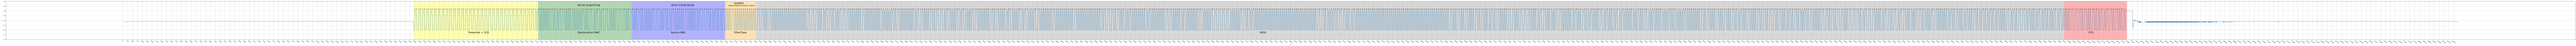

In [29]:
def compute_section_midpoint(df, start, end):
    local_midpoint = (start + end)//2
    p = int(df.loc[df.n == local_midpoint].reset_index().iloc[:, 0].mean())
    return p

# Plot the segments shaded over the raw waveform.
xticks = np.arange(0, len(df), 250)

fig, ax = plt.subplots()
plot = df.Volt.plot(
        figsize=(400, 6),  
        ax=ax, 
        xlabel='ns', 
        ylabel='V', 
        #color='red', 
        ylim=(-2, 2), 
        grid=True, 
        xticks=xticks
    )

xticks = np.arange(0, len(df), 10)
plt.xticks(rotation=-30)

# Shade regions for different sections of ethernet header, and annotate the sections
ax.fill_between(df.index, 4, -4, where=(df.n >= 0) & (df.n < dest_mac_start), facecolor='yellow', alpha=.3, offsets=(-15,0))
p = compute_section_midpoint(df, 1, dest_mac_start)
ax.annotate(text='Preamble + SFD', xy=(p-500, -1.35), fontsize=22)

ax.fill_between(df.index, 4, -4, where=(df.n >= dest_mac_start) & (df.n < source_mac_start), facecolor='green', alpha=.3, offsets=(-15,0))
p2 = compute_section_midpoint(df, dest_mac_start, dest_mac_stop)
ax.annotate(text='Destionation MAC', xy=(p2-500, -1.35), fontsize=22)
ax.annotate(text=d_mac, xy=(p2-500, 1.5), fontsize=22)

ax.fill_between(df.index, 4, -4, where=(df.n >= source_mac_start) & (df.n < ethertype_start), facecolor='blue', alpha=.3, offsets=(-15,0))
p3 = compute_section_midpoint(df, source_mac_start, source_mac_stop)
ax.annotate(text='Source MAC', xy=(p3-500, -1.35), fontsize=22)
ax.annotate(text=s_mac, xy=(p3-500, 1.5), fontsize=22)

ax.fill_between(df.index, 4, -4, where=(df.n >= ethertype_start) & (df.n < ethertype_stop), facecolor='orange', alpha=.3, offsets=(-15,0))
p4 = compute_section_midpoint(df, ethertype_start, ethertype_stop)
ax.annotate(text='EtherType', xy=(p4-450, -1.35), fontsize=22)
ax.annotate(text=ethertype_lookup.Hex.iloc[0], xy=(p4-450, 1.7), fontsize=22)
ax.annotate(text=ethertype_lookup.Ethertype.iloc[0], xy=(p4-750, 1.5), fontsize=14)

# red out 'data' section or make it gray, idk
# do I want to go into more depth like drill down to IP? not necesarilly. I want to use higher level 
# abstractions to look at that information, later, though. Just not on the bit stream... or do I? xD
ax.fill_between(df.index, 4, -4, where=(df.n >= ethertype_stop) & (df.n < fcs_start), facecolor='gray', alpha=.3, offsets=(-15,0))
p5 = compute_section_midpoint(df, ethertype_stop, 700)
ax.annotate(text='DATA', xy=(p5-450, -1.35), fontsize=22)

ax.fill_between(df.index, 4, -4, where=(df.n >= fcs_start) & (df.n < fcs_stop), facecolor='red', alpha=.3, offsets=(-15,0))
p6 = compute_section_midpoint(df, fcs_start, fcs_stop)
ax.annotate(text='FCS', xy=(p6-450, -1.35), fontsize=22)

for i, row in df.loc[~df.Q.isna()].iterrows():
    ax.annotate(text=row.Q, xy=(i - 40, 1.1), fontsize=15)  # 0.10

#fig.savefig('figure.png')

In [20]:
# check CRC
ether_crc = ''.join(frame_bytes[-4:])
frame_less_crc = ''.join(frame_bytes[:-4])
a = int(frame_less_crc, base=2)
num_bytes = len(frame_bytes)-4
bytes = a.to_bytes(num_bytes, 'big')
#bytes

#hex(zlib.crc32(bytes) & 0xffffffff)
#hex(int(ether_crc, base=2))
zlib.crc32(bytes) % (1<<32)
#int(ether_crc, base=2)

3300279464

In [21]:
#a = 2
#a.to_bytes(2, 'big')

In [22]:
calc = crc.Calculator(crc.Crc32.CRC32)
len(bin(calc.checksum(bytes))[2:])
#len(ether_crc)
#ether_crc
crcbits = ''.join(reverse_octets(chunk_octets(ether_crc)))
int(crcbits, base=2)

354577699

In [23]:
len(frame_bits[:-32])/8
a = int(frame_bits[:-32], base=2)
bytes = a.to_bytes(98, 'big')
bytes
zlib.crc32(bytes) % (1<<32)

3474011142

In [24]:
int(ether_crc, base=2)

2823075524